## Introduction <a class="anchor" id="Introduction"></a>

#### PurgedGroupTimeSeries CV + Optuna - LightGBM Version

This is a simple notebook for the G-Research Crypto Competition.This is a simple starter notebook for Kaggle's Crypto Comp showing purged group timeseries KFold with extra data.The original notebook is from Yam Peleg, a kaggle grandmaster. Many of the explanations are borrowed from Yam. I dive into feature engineering and exploring the data a little more. There are many configuration variables below to allow you to experiment. Use either CPU or GPU. You can control which years are loaded, which neural networks are used, and whether to use feature engineering. You can experiment with different data preprocessing, model hyperparameters, loss, and number of seeds to ensemble. The extra datasets contain the full history of the assets at the same format of the competition, so you can input that into your model too.

NOTE: this notebook lets you run a different experiment in each fold if you want to run lots of experiments. (Then it is like running multiple holdout validation experiments but in that case note that the overall CV score is meaningless because LB will be much different when the multiple experiments are ensembled to predict test). If you want a proper CV with a reliable overall CV score you need to choose the same configuration for each fold.

This notebook follows the ideas presented in my "Initial Thoughts" here. Some code sections have been reused from Chris' great notebook series on SIIM ISIC melanoma detection competition here


### Table of Contents <a class="anchor" id="Tableofcontents"></a>

1. [Introduction](#Introduction)

2. [Table of Contents](#Tableofcontents)

2. [Light GBM](#LightGBM)

3. [Hyper Parameter Tunning in Light GBM](#Tuning)

3. [Optuna](#Optuna)

4. [Purged Group Time Series](#Purged)

5. [Diving into the data](#Diving)

6. [Evaluation](#Evaluation)
    
. [Model](#ModelTraining)


## Light GBM <a class="anchor" id="LightGBM"></a>

LightGBM is the current "Meta" on kaggle and it doesn't look like it is going to get Nerfed anytime soon! It is basiclly a "light" version of gradient boosting machines framework that aims to increases efficiency and reduces memory usage.

It is usually THE Algorithm everyone on Kaggle try when facing a tabular dataset

TL;DR: What makes LightGBM so great:
LGBM was developed and maintained by Microsoft themselves so it gets constant maintenance and support.
Easy to use
Faster than nearly all other gradient boosting algorithms.
Usually the most powerful gradient boosting.
It is a gradient boosting model that makes use of tree based learning algorithms. It is considered to be a fast processing algorithm.

While other algorithms trees grow horizontally, LightGBM algorithm grows vertically, meaning it grows leaf-wise and other algorithms grow level-wise. LightGBM chooses the leaf with large loss to grow. It can lower down more loss than a level wise algorithm when growing the same leaf.

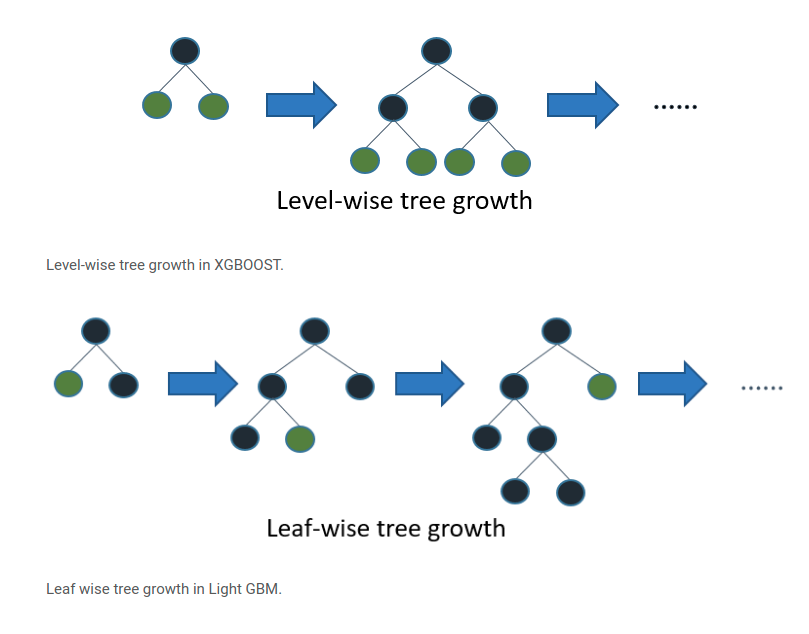

Light GBM is prefixed as Light because of its high speed. Light GBM can handle the large size of data and takes lower memory to run.

Another reason why Light GBM is so popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development.

Leaf growth technique in LightGBM
LightGBM uses leaf-wise (best-first) tree growth. It chooses to grow the leaf that minimizes the loss, allowing a growth of an imbalanced tree. Because it doesn’t grow level-wise, but leaf-wise, over-fitting can happen when data is small. In these cases, it is important to control the tree depth.

LightGBM vs XGBoost
base learner of almost all of the competitions that have structured datasets right now. This is mostly because of LightGBM's implementation; it doesn't do exact searches for optimal splits like XGBoost does in it's default setting but rather through histogram approximations (XGBoost now has this functionality as well but it's still not as fast as LightGBM).

This results in slight decrease of predictive performance buy much larger increase of speed. This means more opportunity for feature engineering/experimentation/model tuning which inevitably yields larger increases in predictive performance. (Feature engineering are the key to winning most Kaggle competitions)

LightGBM vs Catboost
CatBoost is not used as much, mostly because it tends to be much slower than LightGBM and XGBoost. That being said, CatBoost is very different when it comes to the implementation of gradient boosting. This can give slightly more accurate predictions, in particular if you have large amounts of categorical features. Because rapid experimentation is vital in Kaggle competitions, LightGBM tends to be the go-to algorithm when first creating strong base learners.

In general, it is important to note that a large amount of approaches involves combining all three boosting algorithms in an ensemble. LightGBM, CatBoost, and XGBoost might be thrown together in a mix to create a strong ensemble. This is done to really squeeze spots on the leaderboard and it usually works.


### Hyperparameter tuning in Light GBM <a class="anchor" id="Tuning"></a>

Parameter Tuning is an important part that is usually done by data scientists to achieve a good accuracy, fast result and to deal with overfitting. Let us see quickly some of the parameter tuning you can do for better results. While, LightGBM has more than 100 parameters that are given in the documentation of LightGBM, we are going to check the most important ones.

num_leaves: This parameter is responsible for the complexity of the model. I normally start by trying values in the range [10,100]. But if you have a solid heuristic to choose tree depth you can always use it and set num_leaves to 2^tree_depth - 1

LightGBM Documentation says in respect - This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

Min_data_in_leaf: Assigning bigger value to this parameter can result in underfitting of the model. Giving it a value of 100 or 1000 is sufficient for a large dataset.

Max_depth: Controls the depth of the individual trees. Typical values range from a depth of 3–8 but it is not uncommon to see a tree depth of 1. Smaller depth trees are computationally efficient (but require more trees); however, higher depth trees allow the algorithm to capture unique interactions but also increase the risk of over-fitting. Larger training data sets are more tolerable to deeper trees.

num_iterations: Num_iterations specifies the number of boosting iterations (trees to build). The more trees you build the more accurate your model can be at the cost of:
- Longer training time
- Higher chance of over-fitting
So typically start with a lower number of trees to build a baseline and increase it later when you want to squeeze the last % out of your model.

It is recommended to use smaller learning_rate with larger num_iterations. Also, we should use early_stopping_rounds if we go for higher num_iterations to stop your training when it is not learning anything useful.

early_stopping_rounds - "early stopping" refers to stopping the training process if the model's performance on a given validation set does not improve for several consecutive iterations. This parameter will stop training if the validation metric is not improving after the last early stopping round. It should be defined in pair with a number of iterations. If we set it too large we increase the chance of over-fitting. The rule of thumb is to have it at 10% of your num_iterations.

### Other Parameters Overview
Parameters that control the trees of LightGBM

num_leaves: controls the number of decision leaves in a single tree. there will be multiple trees in pool.
min_data_in_leaf: the minimum number of data/sample/count per leaf (default is 20; lower min_data_in_leaf means less conservative/control, potentially overfitting).
max_depth: this the height of a decision tree. if its more possibility of overfitting but too low may underfit.
NOTE: max_depth directly impacts:

The best value for the num_leaves parameter
Model Performance
Training Time

### Parameters For Better Accuracy

* Use large max_bin (may be slower)
* Use small learning_rate with large num_iteration
* Use large num_leaves (may cause over-fitting)
* Use bigger training data
* Try dart

### Parameters for Dealing with Over-fitting

* Use small max_bin
* Use small num_leaves
* Use min_data_in_leaf and min_sum_hessian_in_leaf
* Use bagging by set bagging_fraction and bagging_freq
* Use feature sub-sampling by set feature_fraction
* Use bigger training data
* Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
* Try max_depth to avoid growing deep tree
* Try extra_trees
* Try increasing path_smooth

### How to tune LightGBM like a boss?
Hyperparameters tuning guide:

#### objective

* When you change it affects other parameters Specify the type of ML model
* default- value regression
* aliases- Objective_type

#### boosting

* If you set it RF, that would be a bagging approach
* default- gbdt
* Range- [gbdt, rf, dart, goss]
* aliases- boosting_type

#### lambda_l1

* regularization parameter
* default- 0.0
* Range- [0, ∞]
* aliases- reg_alpha
* constraints- lambda_l1 >= 0.0

#### bagging_fraction

* randomly select part of data without resampling
* default-1.0
* range- [0, 1]
* aliases- Subsample
* constarints- 0.0 < bagging_fraction <= 1.0

#### bagging_freq

* default- 0.0
* range- [0, ∞]
* aliases- subsample_freq
* bagging_fraction should be set to value smaller than 1.0 as well 0 means disable bagging

#### num_leaves

* max number of leaves in one tree
* default- 31
* Range- [1, ∞]
* Note- 1 < num_leaves <= 131072

#### feature_fraction

* if you set it to 0.8, LightGBM will select 80% of features
* default- 1.0
* Range- [0, 1]
* aliases- sub_feature
* constarint- 0.0 < feature_fraction <= 1.0

#### max_depth

* default- [-1]
* range- [-1, ∞]m
* Larger is usually better, but overfitting speed increases.
* limit the max depth Forr tree model
* max_bin

* deal with over-fitting
* default- 255
* range- [2, ∞]
* aliases- Histogram Binning
* max_bin > 1

#### num_iterations

* number of boosting iterations
* default- 100
* range- [1, ∞]
* AKA- Num_boost_round, n_iter
* constarints- num_iterations >= 0

#### learning_rate

* default- 0.1
* range- [0 1]
* aliases- eta
* general values- learning_rate > 0.0Typical: 0.05.

#### early_stopping_round

* will stop training if validation doesn’t improve in last early_stopping_round
* Model Performance, Number of Iterations, Training Time
* default- 0
* Range- [0, ∞]

#### categorical_feature

* to sepecify or Handle categorical features
* i.e LGBM automatically handels categorical variable we dont need to one hot encode them.

#### bagging_freq

* default-0.0
* Range-[0, ∞]
* aliases- subsample_freq
* note- 0 means disable bagging; k means perform bagging at every k iteration
* enable bagging, bagging_fraction should be set to value smaller than 1.0 as well

#### verbosity

* default- 0
* range- [-∞, ∞]
* aliases- verbose
* constraints- {< 0: Fatal, = 0: Error (Warning), = 1: Info, > 1}

#### min_data_in_leaf

* Can be used to deal with over-fitting:
* default- 20
* constarint-min_data_in_leaf >= 0


Credits: The following notebook is heavily based on multiple notebook of the past Jane street market prediction competition. If you find it useful, spare some upvotes to the originals. They earned it!

"Purged Time Series CV, XGBoost, Optuna 🔪📆" by MARKETNEUTRAL - https://www.kaggle.com/marketneutral/purged-time-series-cv-xgboost-optuna

## Optuna <a class="anchor" id="Optuna"></a>

What is Optuna? Here is an explanation taken straight from the official GitHub. 

Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. Thanks to our define-by-run API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd 
import os 
import datetime
import gc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import numpy as np
from datetime import datetime
from lightgbm import LGBMRegressor
import optuna
import plotly.graph_objects as go
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
import lightgbm as lgb
import getpass
import boto3
import seaborn as sns
import gresearch_crypto
import traceback
from sklearn.metrics import roc_auc_score, mean_absolute_error
import datatable as dt

In [3]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = len(train_array)
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [4]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
crypto_df = pd.read_csv('../input/g-research-crypto-forecasting/train.csv')
test = pd.read_csv('../input/g-research-crypto-forecasting/example_sample_submission.csv')
asset_details = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')

crypto_df.head(2)

In [6]:
test.head(2)

In [7]:
asset_details.head(2)

In [8]:
asset_weight_dict = {asset_details['Asset_ID'].tolist()[idx]: asset_details['Weight'].tolist()[idx] for idx in range(len(asset_details))}
asset_name_dict = {asset_details['Asset_ID'].tolist()[idx]: asset_details['Asset_Name'].tolist()[idx] for idx in range(len(asset_details))}

In [9]:
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp") # Asset_ID = 1 for Bitcoin
btc_mini = btc.iloc[-200:] # Select recent data rows

In [10]:
fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

In [11]:
crypto_df.isna().sum()

In [12]:
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

# A utility function to build features from the original df
def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat["open_sub_close"] = df_feat["Open"] - df_feat["Close"]
    return df_feat

In [13]:
def fill_nan_inf(df):
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    return df


crypto_df['date'] = pd.to_datetime(crypto_df['timestamp'], unit = 's')
crypto_df = crypto_df.sort_values('date')
groups = pd.factorize(crypto_df['date'].dt.day.astype(str) + '_' + crypto_df['date'].dt.month.astype(str) + '_' + crypto_df['date'].dt.year.astype(str))[0]
dates = crypto_df['date'].copy()
target = crypto_df['Target'].copy()
timestamp = crypto_df['timestamp'].copy()
crypto_df.drop(columns = 'Target', inplace = True)
crypto_df = reduce_mem_usage(crypto_df)
assets_idx = crypto_df['Asset_ID']
crypto_df = get_features(crypto_df)
crypto_df['Asset_ID'] = assets_idx
crypto_df['groups'] = groups
crypto_df['date'] = dates
crypto_df = reduce_mem_usage(crypto_df)
crypto_df['Target'] = target
crypto_df['timestamp'] = timestamp
crypto_df['Weight'] = crypto_df['Asset_ID'].map(asset_weight_dict)

crypto_df = fill_nan_inf(crypto_df)
test = fill_nan_inf(test)

feature_names = [i for i in crypto_df.columns if i not in ['Target', 'date', 'timestamp', 'VWAP', 'Asset_ID', 'groups', 'Weight']]

In [14]:
y_labels = crypto_df['Target'].values
X_train = crypto_df[feature_names].values
weights = crypto_df['Weight'].values
groups = crypto_df['groups'].values

### Model Training <a class="anchor" id="ModelTraining"></a>

In [15]:
DEVICE = 'CPU'

# CV PARAMS
FOLDS = 5
GROUP_GAP = 130
MAX_TEST_GROUP_SIZE = 180
MAX_TRAIN_GROUP_SIZE = 280

# LOAD STRICT? YES=1 NO=0 | see: https://www.kaggle.com/julian3833/proposal-for-a-meaningful-lb-strict-lgbm
LOAD_STRICT = True

cv = PurgedGroupTimeSeriesSplit(n_splits = FOLDS,
    group_gap = GROUP_GAP,
    max_train_group_size = MAX_TRAIN_GROUP_SIZE,
    max_test_group_size = MAX_TEST_GROUP_SIZE
)

def objective(trial, cv=cv, cv_fold_func=np.average):

    # Optuna suggest params
    param_lgb = {
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }    
    # setup the pieline
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler = StandardScaler()
    param_lgb['verbose'] = 0
    clf = LGBMRegressor(**param_lgb)

    pipe = Pipeline(steps=[
        ('imputer', imp_mean),
        ('scaler', scaler),
        ('catb', clf)
    ])
    
    maes = []
    for i, (train_idx, valid_idx) in enumerate(cv.split(
        X_train,
        y_labels,
        groups=groups)):
        
        train_data = X_train[train_idx, :], y_labels[train_idx]
        valid_data = X_train[valid_idx, :], y_labels[valid_idx]
        
        _ = pipe.fit(X_train[train_idx, :], y_labels[train_idx])
        preds = pipe.predict(X_train[valid_idx, :])
        mae = mean_absolute_error(y_labels[valid_idx], preds)
        maes.append(mae)
    
    print(f'Trial done: mae values on folds: {maes}')
    return -1.0 * cv_fold_func(maes)

In [16]:
%%time

FIT_LGB = True

n_trials = 30

if FIT_LGB:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    best_params = trial.params        
else: best_params = {}

In [17]:
best_params

In [18]:
def corr(a, b, w):
    cov = lambda x, y: np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)
    return cov(a, b) / np.sqrt(cov(a, a) * cov(b, b))

# LGBM Version
def get_lgbm_metric(w):
    def lgbm_wcorr(preds, y_true): return 'lgbm_wcorr', corr(preds, y_true, w), True
    return lgbm_wcorr

In [20]:
# verbose = 0 for silent, verbose = 1 for interactive
best_params['verbose'] = 0

importances, maes, models = [], [], []
oof = np.zeros(len(X_train))
for i, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_labels, groups=groups)):    
    clf = LGBMRegressor(**best_params)
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler = StandardScaler()
    pipe = Pipeline(steps=[('imputer', imp_mean), ('scaler', scaler), ('catb', clf)])
    _ = pipe.fit(X_train[train_idx, :], y_labels[train_idx])
    preds = pipe.predict(X_train[valid_idx, :])
    oof[valid_idx] = preds
    models.append(pipe)
    importances.append(clf.feature_importances_)
    mae = mean_absolute_error(y_labels[valid_idx], preds)
    maes.append(mae)        
    score = corr(np.nan_to_num(y_labels[valid_idx].flatten()), np.nan_to_num(preds.flatten()), np.nan_to_num(weights[valid_idx]))
    print(f'Fold {i}: wcorr score: {score}')
    
print(f'Score: {corr(y_labels.flatten(), oof.flatten(), weights)}')

In [21]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
pd.options.mode.chained_assignment = None

def plot_importance(importances, features_names, PLOT_TOP_N = 20, figsize=(12, 20)):
    try: plt.close()
    except: pass
    importance_df = pd.DataFrame(data=importances, columns=features_names)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    plt.title('Feature Importances')
    sns.boxplot(data=sorted_importance_df[plot_cols], orient='h', ax=ax)
    plt.show()
    
    
pd.DataFrame({'timestamp': crypto_df['timestamp'], 'asset_id': crypto_df['Asset_ID'], 'oof_preds': oof}).to_csv('oof.csv', index = False)

for asset in crypto_df['Asset_ID'].unique().tolist():       
    df = crypto_df.loc[crypto_df['Asset_ID'] == asset]
    df['oof_preds'] = np.nan_to_num(oof[crypto_df['Asset_ID'] == asset])
    df['Target'] = np.nan_to_num(df['Target'])
    df['y'] = np.nan_to_num(df['Target'])
    
    print('\n\n' + ('-' * 80) + '\n' + 'Finished training %s. Results:' % asset_name_dict[asset])
    print('Model: r2_score: %s | pearsonr: %s ' % (r2_score(df['y'], df['oof_preds']), pearsonr(df['y'], df['oof_preds'])[0]))
    print('Predictions std: %s | Target std: %s' % (df['oof_preds'].std(), df['y'].std()))
    
    try: plt.close()
    except: pass   
    df2 = df.reset_index().set_index('date')
    fig = plt.figure(figsize = (12, 6))
    # fig, ax_left = plt.subplots(figsize = (12, 6))
    ax_left = fig.add_subplot(111)
    ax_left.set_facecolor('azure')    
    ax_right = ax_left.twinx()
    ax_left.plot(df2['y'].rolling(3 * 30 * 24 * 60).corr(df2['oof_preds']).iloc[::24 * 60], color = 'crimson', label = "Target WCorr")
    ax_right.plot(df2['Close'].iloc[::24 * 60], color = 'darkgrey', label = "%s Close" % asset_name_dict[asset])   
    plt.legend()
    plt.grid()
    plt.xlabel('Time')
    plt.title('3 month rolling pearsonr for %s' % (asset_name_dict[asset]))
    plt.show()
    
    plot_importance(np.array(importances), feature_names, PLOT_TOP_N = 20)
    
gc.collect()

In [22]:
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

In [23]:
all_df_test = []
for i, (df_test, df_pred) in enumerate(iter_test):
    for j , row in df_test.iterrows():
        try:            
            x_test = get_features(row)
            x_test = fill_nan_inf(x_test)
            y_pred = np.mean(np.concatenate([np.expand_dims(model.predict([x_test[feature_names].values]), axis = 0) for model in models], axis = 0), axis = 0)
        except: 
            y_pred = 0.0
            traceback.print_exc()
        df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
    all_df_test.append(df_test)
    env.predict(df_pred)